In [1]:

import matplotlib.pyplot as plt
import torch
from model_vae_16_dim import Autoencoder
from torch.utils.data import DataLoader 
from custom_dataset import CustomDataset
from torchvision import transforms
import torchvision.utils as vutils
import os
import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
model_path = '/mayo_atlas/home/m296984/visual_dictionary_pipeline/vae_logs/mse_vae/checkpoint_20.pt'
slide_data_path = '/mayo_atlas/home/m296984/visual_dictionary_pipeline/training_32x32_patches'
PATCH_SIZE = 32
model = Autoencoder(PATCH_SIZE)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
dataset = CustomDataset(data_path=slide_data_path, transform=transforms.ToTensor())
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=32)


In [3]:
def get_embeddings_VAE(model_path, patch_size, slide_data_path, save_path):
    model = Autoencoder(patch_size)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    dataset = CustomDataset(data_path=slide_data_path, transform=transforms.ToTensor())
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=32)
    for i, (photo, _) in enumerate(loader):
        photo = photo.to(device)
        _, embedding, _ = model(photo)
        file_name = f"embedding_{i}.pt"
        file_path = os.path.join(save_path, file_name)
        
        # Save the current embedding tensor to the specified file path
        torch.save(embedding, file_path)

In [5]:
print(device)
num_words = 1000
word_size = 32
model = 'VAE_32x32_16_dim'
keywords = ["train", "test"]
for keyword in keywords: 
    MODEL_PATH = '/mayo_atlas/home/m296984/visual_dictionary_pipeline/vae_logs/mse_vae/checkpoint_20.pt'
    DATA_PATH = f'/mayo_atlas/home/m296984/visual_dictionary_pipeline/{keyword}/{num_words}_words_per_slide_{word_size}'
    SAVE_PATH = f'/mayo_atlas/home/m296984/visual_dictionary_pipeline/{keyword}/embeddings_{num_words}_{model}'
    os.makedirs(SAVE_PATH, exist_ok=True)
    slide_names = os.listdir(DATA_PATH)
    for slide_name in tqdm.tqdm(slide_names, total=len(slide_names), desc="Saving Embeddings:"):
        slide_save_path = os.path.join(SAVE_PATH, slide_name)
        slide_data_path = os.path.join(DATA_PATH, slide_name)
        if any(os.scandir(slide_data_path)):
            os.makedirs(slide_save_path, exist_ok=True)
            # if model == "VAE_32x32":
            get_embeddings_VAE(MODEL_PATH, PATCH_SIZE, slide_data_path, slide_save_path)

cuda


Saving Embeddings:: 100%|██████████| 177/177 [13:34<00:00,  4.60s/it]


In [3]:
def visualize_images(original_images, reconstructed_images):
    _, axes = plt.subplots(nrows=2, ncols=len(original_images), figsize=(12, 4))

    for i, ax in enumerate(axes[0]):
        ax.imshow(original_images[i].transpose(1, 2, 0))
        ax.axis('off')
        ax.set_title('Original')

    for i, ax in enumerate(axes[1]):
        ax.imshow(reconstructed_images[i].transpose(1, 2, 0))
        ax.axis('off')
        ax.set_title('Reconstructed')

    plt.show()

In [6]:
# Visualize a small sample of images
num_samples = 2  # Number of samples to visualize

original_images = []
reconstructed_images = []
for i, (photo, _) in enumerate(loader):
    if i >= num_samples:
        break
    input_images = photo.to(device)
    # Forward pass through the model to get the reconstructed output
    with torch.no_grad():
        reconstructed_image, _, _ = model(input_images)
        
        
    original_images.append(input_images.cpu().numpy().squeeze())
    reconstructed_images.append(reconstructed_image.cpu().numpy().squeeze())

tensor([[-1.8690e-04,  8.6804e-04, -9.8463e-05, -5.4067e-05, -5.1846e-04,
         -9.8336e-04,  9.2605e-04, -1.6752e-04]], device='cuda:0')
tensor([[ 7.6070e-06, -8.9824e-05,  3.6042e-06,  1.6615e-06,  3.4675e-05,
          1.1605e-04, -1.0206e-04,  6.3553e-06]], device='cuda:0')


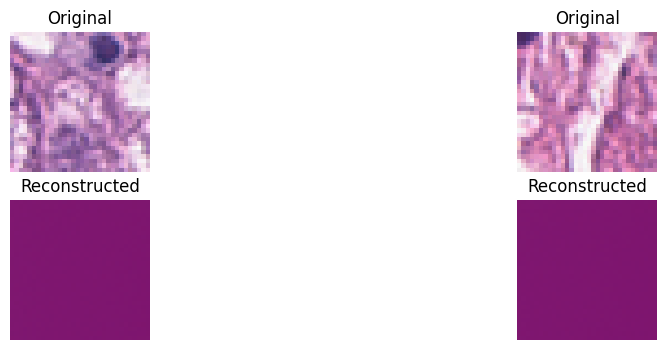

In [5]:
visualize_images(original_images, reconstructed_images)

In [23]:
for i in range(num_samples):
    # Save the original image
    vutils.save_image(original_images[i], "/mayo_atlas/home/m296984/visual_dictionary_pipeline/image_reconstruction/original/original_image_{}.png".format(i))
    # Save the reconstructed image
    vutils.save_image(reconstructed_images[i], "/mayo_atlas/home/m296984/visual_dictionary_pipeline/image_reconstruction/reconstructed/reconstructed_image_{}.png".format(i))